**Import libraries and define system parameters**

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from utils import calculate_num_sensors, calculate_graph_matrices, is_graph_connected, get_field_function, get_sensor_measurements, visualize_graphs, calculate_error

FIELD_SIZE = 100
FIELD_RANGE = np.array([[0, FIELD_SIZE], [0, FIELD_SIZE]])

# True measurement function
field_function = get_field_function()

COMM_RANGE = 50
NUM_SENSORS = calculate_num_sensors(COMM_RANGE, FIELD_SIZE, 2)
print("Selected number of sensors:", NUM_SENSORS)

Selected number of sensors: 27


**Generate random graph**

The graph is connected.
Average temperature: 18.68 C


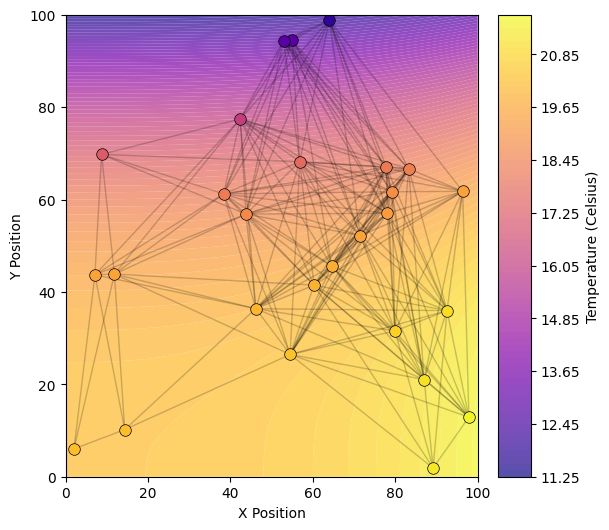

In [41]:
# Set random seed for reproducibiliy
np.random.seed(0)

# Randomly generate sensor locations within the field
sensor_locations = np.array([np.random.uniform(FIELD_RANGE[0,0], FIELD_RANGE[0,1], NUM_SENSORS),
                            np.random.uniform(FIELD_RANGE[1,0], FIELD_RANGE[1,1], NUM_SENSORS)])

# Calculate the adjacency matrix, degree matrix, and Laplacian matrix
adjacency_matrix, degree_matrix, laplacian_matrix = calculate_graph_matrices(sensor_locations, COMM_RANGE)
# Determine if the graph is connected
if not is_graph_connected(laplacian_matrix):
    print("Warning: The graph is not connected.")
else:
    print("The graph is connected.")

# Generate sensor measurements from the field function
noise_std = 0
sensor_measurements = get_sensor_measurements(sensor_locations, field_function, noise_std)
average_temperature = np.mean(sensor_measurements)
print("Average temperature:", "{:.2f}".format(average_temperature), "C")

# Visualize the sensor locations and the communication graph
visualize_graphs(sensor_locations, adjacency_matrix, field_function, sensor_measurements)

**Randomized Gossip**

[1.00001481 0.98077068 0.98076543 0.98076415 0.9807532  0.98074719
 0.98008781 0.9795963  0.9795963  0.97943869 0.97861546 0.97628333
 0.97285982 0.97127881 0.97057921 0.96797426 0.96763557 0.96566414
 0.96377227 0.95794969 0.9568453  0.94586325 0.93652812 0.92781073
 0.92328004 0.90358785 0.89132279]
[1.         0.99100001 0.98368403 0.97656343 0.97109862 0.96771992
 0.96622082 0.96586958 0.96396131 0.96191742 0.96139447 0.96039077
 0.95988776 0.95902251 0.95800197 0.95769332 0.95769332 0.95647377
 0.95598492 0.9558902  0.95553335 0.95452253 0.95425869 0.95326067
 0.9527939  0.95001153 0.9491512 ]
The optimal P matrix is better than the uniform distribution.


Text(0.5, 1.0, 'Randomized Gossip Algorithm: Error vs Iteration')

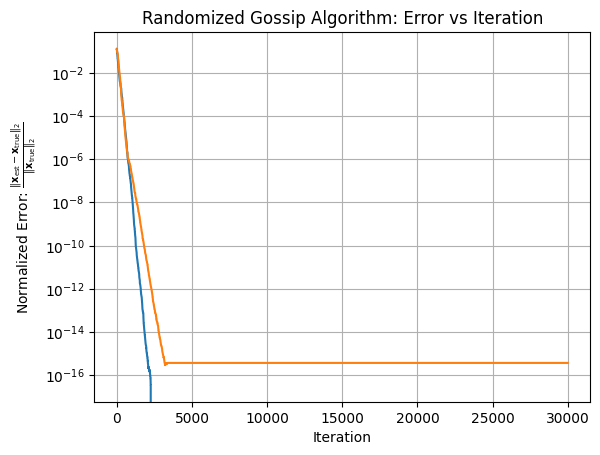

In [42]:
def get_p_matrix(adjacency_matrix):
    n = adjacency_matrix.shape[0]
    W_bar = cvx.Variable((n, n), symmetric=True)
    P = cvx.Variable((n, n))
    constraints = [W_bar >> 0]

    W_bar.value = get_W_bar(adjacency_matrix / np.sum(adjacency_matrix, axis=1, keepdims=True), adjacency_matrix)

    Wij_list = []
    for i in range(0, n):
        for j in range(0, n):
            if (adjacency_matrix[i, j] > 0):
                e_i = np.zeros((n, 1)); e_i[i] = 1
                e_j = np.zeros((n, 1)); e_j[j] = 1
                W_ij = np.eye(n) - 0.5 * (e_i - e_j) @ (e_i - e_j).T
                Wij_list.append(W_ij)

    Wij_flat = np.array([W.flatten() for W in Wij_list]) 
    p = cvx.Variable(len(Wij_list), nonneg=True)
    W_bar_vec = p @ Wij_flat / n  # CVXPY expression

    # Reshape back to matrix
    W_bar = cvx.reshape(W_bar_vec, (n, n))

    cnt = 0
    for i in range(0, n):
        for j in range(0, n):
            if (adjacency_matrix[i, j] > 0):
                constraints.append(P[i, j] == p[cnt])
                cnt += 1
            else:
                constraints.append(P[i, j] == 0)
        constraints.append(cvx.sum(P[i, :]) == 1)

    one_vec = np.ones((n, 1))
    J = np.eye(n) - one_vec @ one_vec.T / n
    W_proj = J @ W_bar @ J

    obj = cvx.Minimize(cvx.lambda_max(W_proj))
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.SCS)

    return np.round(P.value, 4)

def get_W_bar(P, adjacency_matrix):
    n = adjacency_matrix.shape[0]
    W_bar = np.zeros_like(adjacency_matrix, dtype='float64')

    for i in range(0, n):
        for j in range(0, n):
            if (adjacency_matrix[i, j] > 0):
                e_i = np.zeros((n, 1)); e_i[i] = 1
                e_j = np.zeros((n, 1)); e_j[j] = 1
                W_ij = np.eye(n) - 0.5 * (e_i - e_j) @ (e_i - e_j).T
                W_bar += P[i, j] * W_ij
    
    return W_bar / n

# Implements the randomized gossip algorithm for the specified number of iterations
def randomized_gossip(adjacency_matrix, sensor_measurements, P, num_iter):
    num_sensors = adjacency_matrix.shape[0]
    error_vals = []
    true_average = np.mean(sensor_measurements) * np.ones(num_sensors)
    est_average = sensor_measurements.copy()
    
    for iter in range(0, num_iter):
        # Randomly choose a sensor
        i = np.random.randint(0, num_sensors)
        # Randomly choose a neighbor 
        # TODO: find the P matrix that will optimize the gossip algorithm
        j = np.random.choice(len(P[i]), p=P[i]/sum(P[i]))
        # Compute the average of the two selected sensors
        average_val = 0.5*(est_average[i] + est_average[j])
        est_average[i] = average_val
        est_average[j] = average_val
        # Calculate the error
        error_val = calculate_error(est_average, true_average)
        error_vals.append(error_val)

    return error_vals, est_average

P_opt = get_p_matrix(adjacency_matrix)
P_nat = adjacency_matrix / np.sum(adjacency_matrix, axis=1, keepdims=True)
W_bar1 = get_W_bar(P_opt, adjacency_matrix)
W_bar2 = get_W_bar(P_nat, adjacency_matrix)
print(np.linalg.eigvalsh(W_bar1)[::-1])
print(np.linalg.eigvalsh(W_bar2)[::-1])
if (np.linalg.eigvalsh(W_bar1)[::-1][1] < np.linalg.eigvalsh(W_bar2)[::-1][1]):
    print("The optimal P matrix is better than the uniform distribution.")
else:
    print("The uniform distribution is better than the optimal P matrix.")

error_vals1, est_average1 = randomized_gossip(adjacency_matrix, sensor_measurements, P_opt, 30000)
error_vals2, est_average2 = randomized_gossip(adjacency_matrix, sensor_measurements, P_nat, 30000)

plt.semilogy(error_vals1)
plt.semilogy(error_vals2)

plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel(r"Normalized Error: $\frac{\|\mathbf{x}_{\mathrm{est}} - \mathbf{x}_{\mathrm{true}}\|_2}{\|\mathbf{x}_{\mathrm{true}}\|_2}$")
plt.title("Randomized Gossip Algorithm: Error vs Iteration")